# Basic Data Science in Python - Project
## Leihui Li; leihui@mpe.au.dk ##

This handin is indiviual and mandatory to pass the course.

Hand in this .ipynb file, no later than 10/11 kl 23:59. 

### Project description
For this project, you have almost no limitations. You are going to be working with a [smoke detection dataset](https://www.hackster.io/stefanblattmann/real-time-smoke-detection-with-ai-based-sensor-fusion-1086e6), to classify a fire alarm. The dataset is located in the data folder, as $\texttt{smoke\_detection.csv} $.

Remember before you begin, to inspect the data - i.e does it need cleaning, what are you working with? Also, remember to seperate the dataset in two - the labels ("Fire Alarm"), and the rest of the data.

Concretely, you should use your knowledge of testing, overfitting, and the pros and cons of different models, to predict Fire Alarm (0 for no alarm, 1 for alarm) from the different air quality measures. Try at least two different methods. You must reason about your choice of methods, as well as evaluate your results. Can you visualize your results somehow?

In [1]:
import random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
csv_data = pd.read_csv('../data/smoke_detection.csv')
print (csv_data.head)

features, labels = csv_data.iloc[:, 2:-2].to_numpy(), csv_data.iloc[:,-1].to_numpy().reshape(-1,1)
print (features.shape, labels.shape)

<bound method NDFrame.head of        Unnamed: 0         UTC  Temperature[C]  Humidity[%]  TVOC[ppb]  \
0               0  1654733331          20.000        57.36          0   
1               1  1654733332          20.015        56.67          0   
2               2  1654733333          20.029        55.96          0   
3               3  1654733334          20.044        55.28          0   
4               4  1654733335          20.059        54.69          0   
...           ...         ...             ...          ...        ...   
62625       62625  1655130047          18.438        15.79        625   
62626       62626  1655130048          18.653        15.87        612   
62627       62627  1655130049          18.867        15.84        627   
62628       62628  1655130050          19.083        16.04        638   
62629       62629  1655130051          19.299        16.52        643   

       eCO2[ppm]  Raw H2  Raw Ethanol  Pressure[hPa]  PM1.0  PM2.5  NC0.5  \
0            400

## 1. Decision Tree

The dataset has multiple features, such as humidity, eCO2, PM*, etc., it is commonly used for decision tree to make the prediction. It is able to model non-linear relationships in the data. This is particularly useful when the underlying data relationships are non-linear, such as the data presented in the smoke dataset. However, when using a decision tree, it can be difficult to capture complex relationships between the data.

### 1.1 Implementation

In [3]:
# print (features.shape, labels.shape, type(features), type(labels))

from sklearn import tree
np.set_printoptions(precision=3, suppress=True)

X, y = features.copy(), labels.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print (f"Train data length:{X_train.shape}, Test data length:{X_test.shape}")
x_i = random.randint(0, len(X_test))
print (f"Here is an example: we select \"{x_i}\" th in Test data:")
print (f"feature:{X_train[x_i].tolist()} \nIts label is { y_train[x_i].tolist()}")

# Build decision tree and model
clf_model = tree.DecisionTreeClassifier(
    criterion='entropy', 
    splitter = 'random', 
    random_state=42, 
    max_depth=8,
    #min_impurity_decrease = 0.01,
    min_samples_leaf=1,
    min_samples_split=3)
clf_model = clf_model.fit(X_train, y_train)
# evalute by score
clf_score_sample, clf_score_test = clf_model.score(X_train,y_train), clf_model.score(X_test,y_test)     

print (f"The parameters of this decision tree are as follows:")
print (clf_model.get_params())

print (f"Training score: {clf_score_sample} test score: {clf_score_test}")

print (f"We select the {x_i} th among the test data:")
print (f"ground Truth:\n{X_test[x_i].tolist()} -> {y_test[x_i]}")
print (f"predict Result:\n{clf_model.predict(X_test[x_i].reshape(1, -1))}")

Train data length:(37578, 12), Test data length:(25052, 12)
Here is an example: we select "13306" th in Test data:
feature:[20.05, 56.76, 350.0, 400.0, 13067.0, 19914.0, 939.291, 0.33, 0.34, 2.25, 0.352, 0.008] 
Its label is [1]
The parameters of this decision tree are as follows:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'random'}
Training score: 0.9736015753898558 test score: 0.9741737186651764
We select the 13306 th among the test data:
ground Truth:
[17.479, 48.5, 1107.0, 487.0, 12855.0, 19451.0, 938.904, 1.78, 1.85, 12.26, 1.912, 0.043] -> [1]
predict Result:
[1]


According to the result of the decision tree, the accuracy for the test dataset is about 97%, and the trained model also has 97% accuracy. The overfitting does not seem to have happened here.

## 1.2 Visualization 

In [ ]:
text_representation = tree.export_text(clf_model)
print(text_representation)

import sklearn
plt.figure(figsize=(25,20)) # Resize figure
sklearn.tree.plot_tree(clf_model, filled=True)
plt.show()

## 2. Neural Networks

## 2.1 Build the regression model using PyTorch

In [37]:
import torch, time
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from IPython import display
from sklearn.metrics import accuracy_score 

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

train_loss_list, test_loss_list, ac_list = [], [], []
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs.
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary.
    desc -- a description to use for the progress bar.
    """
    running_loss = []
    y_true = []
    y_pred = []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        #Move the batch to the device we are using.
        inputs = moveTo(inputs, device)
        labels = moveTo(labels, device)

        y_hat = model(inputs) #this just computed f_Θ(x(i))
        
        # Compute loss.
        loss = loss_func(y_hat, labels)

        if model.training:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(loss.item())
        if score_funcs is not None:
            if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                #add to predictions so far
                y_true.extend(labels.tolist())
                y_pred.extend(y_hat.tolist())
    #end training epoch
    end = time.time()
    
    y_pred = np.asarray(y_pred)
    if len(y_pred.shape) == 2 and y_pred.shape[1] > 1: #We have a classification problem, convert to labels
        y_pred = np.argmax(y_pred, axis=1)
    #Else, we assume we are working on a regression problem
    
    acc = accuracy_score(y_true, y_pred)
#     print (f'acc:{acc}')
    
#     print(f'loss:{np.mean(running_loss)}')
    if prefix == 'train':
        train_loss_list.append(np.mean(running_loss))
    elif prefix == 'test':
        ac_list.append(acc)
        test_loss_list.append(np.mean(running_loss))
    display.clear_output(wait=True)
    plt.plot(train_loss_list, label = 'train loss')
    plt.plot(test_loss_list, label = 'loss loss')
    plt.plot(ac_list, label = 'accuracy')
    plt.legend()
    plt.show()
    
    results[prefix + " loss"].append( np.mean(running_loss) )
    if score_funcs is not None:
        for name, score_func in score_funcs.items():
            try:
                results[prefix + " " + name].append( score_func(y_true, y_pred) )
            except:
                results[prefix + " " + name].append(float("NaN"))
    return end-start #time spent on epoch

def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=20, device="cpu", checkpoint_file=None, _lr = 0.01):
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    if score_funcs is not None:
        for eval_score in score_funcs:
            to_track.append("train " + eval_score )
            if test_loader is not None:
                to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=_lr)
#     optimizer = torch.optim.Adam(model.parameters(), lr=_lr)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)
    
    return pd.DataFrame.from_dict(results)

class RegressionDataset(Dataset):
    def __init__(self, X, y):
        # super(Simple1DRegressionDataset, self).__init__()
        self.X = X.reshape(-1,12)
        self.y = y.reshape(-1,1)

    def __getitem__(self, index):
        return torch.tensor(self.X[index,:], dtype=torch.float32), torch.tensor(self.y[index], dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]
    
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

In [38]:
## Dataset preparation
device = torch.device("cuda")
# For this dataset, the index number and the UTC may not be helpful, so 12 features could be enough
in_features = 12
out_features = 2
node_num = 10
model = nn.Sequential(
    nn.Linear(in_features, node_num),#hidden layer
    nn.Tanh(),#activation
    nn.Linear(node_num, node_num),#hidden layer
    nn.Tanh(),#activation
    nn.Linear(node_num, node_num),#hidden layer
    nn.Tanh(),#activation
    nn.Linear(node_num, node_num),#hidden layer
    nn.Tanh(),#activation
    nn.Linear(node_num, out_features),#output layer
)
torch.manual_seed(3407)
X, y = features.copy(), labels.copy()
print (X.shape, y.shape)

dataset  = torch.utils.data.TensorDataset(
    torch.tensor(X, dtype=torch.float32).to(device),
    torch.tensor(y.flatten(), dtype=torch.long).to(device))
train_ratio = 0.8
num_of_train_rows = int(X.shape[0]*train_ratio)
num_of_test_rows = int(math.ceil(X.shape[0]*(1-train_ratio)))
print (f"{num_of_train_rows} and {num_of_test_rows} == {X.shape[0]}")

generator1 = torch.Generator().manual_seed(3407)
train_data, test_data = torch.utils.data.random_split(
    dataset, 
    lengths=[num_of_train_rows, num_of_test_rows],
    generator=generator1)

(62630, 12) (62630, 1)
50104 and 12526 == 62630


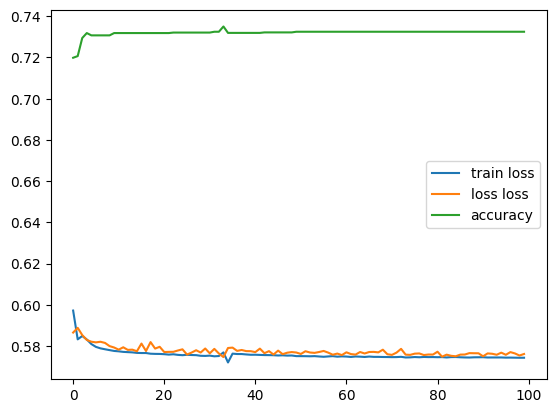

In [39]:
my_epoch = 100
my_lr = 0.01
my_batch_size = 64

training_loader = DataLoader(train_data, shuffle=True,batch_size=my_batch_size)
testing_loader = DataLoader(test_data, shuffle=True, batch_size=512)
## Training
loss_func = nn.CrossEntropyLoss()
checkpoint_name = f'best_epoch_{my_epoch}_lr_{my_lr}_bt_{my_batch_size}'
results = train_simple_network(model,
                               loss_func, training_loader, testing_loader, score_funcs={'Accuracy': accuracy_score},
                               epochs=my_epoch, device=device, checkpoint_file=f'{checkpoint_name}.pt', _lr=my_lr)

    epoch  total time  train loss  test loss  train Accuracy  test Accuracy
0       0    1.634307    0.597235   0.586566        0.705513       0.719863
1       1    3.322193    0.583265   0.588863        0.724333       0.720661
2       2    4.964144    0.584900   0.585342        0.729323       0.729443
3       3    6.666305    0.583200   0.582978        0.733175       0.731838
4       4    8.319234    0.580986   0.582121        0.732736       0.730720
..    ...         ...         ...        ...             ...            ...
95     95  179.357881    0.574404   0.575785        0.734353       0.732476
96     96  181.339846    0.574419   0.577088        0.734353       0.732476
97     97  183.198995    0.574379   0.576437        0.734353       0.732476
98     98  184.969255    0.574340   0.575432        0.734353       0.732476
99     99  186.883230    0.574353   0.576171        0.734353       0.732476

[100 rows x 6 columns]


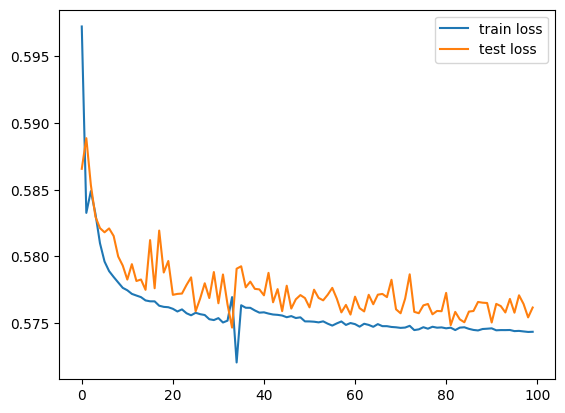

In [40]:
plt.plot(results['train loss'], label='train loss')
plt.plot(results['test loss'], label='test loss')
plt.legend()
plt.savefig(f'{checkpoint_name}.png')
print (results)

In [41]:
checkpoint = torch.load(f'{checkpoint_name}.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

def pref(_x):
    with torch.no_grad():
        _x = torch.as_tensor(_x, dtype=torch.float32).to(device)
        Y_logits = model(_x).clone().detach()
        print (Y_logits, type(Y_logits))
        y_hat = np.argmax(Y_logits.cpu())
        print (y_hat)

user_x_0 = torch.tensor(
    np.array([27.089,55.94,19,400,13010,19919,939.742,0.15,0.15,1.02,0.158,0.004]), 
    dtype =torch.float32).to(device) # 0
user_x_1 = torch.tensor(
    np.array([-1.144,48.22,1325,408,12986,19394,938.809,2.08,2.16,14.33,2.235,0.05]),
    dtype =torch.float32).to(device) # 1

pref(user_x_0)
pref(user_x_1)

tensor([-0.3029,  0.7471], device='cuda:0') <class 'torch.Tensor'>
tensor(1)
tensor([-0.3029,  0.7471], device='cuda:0') <class 'torch.Tensor'>
tensor(1)


##### Your thougths and reflections here

In this section the neural network for smoke detection is designed and implemented. It is a classification problem, so the loss function is chosen as `CrossEntropyLoss`. I have tried several training methods where the structure of the network is consistent and the data set is split again and the number of epochs is changed.

For the training with the same epoch, the result including training loss and test loss is shown below. The reason of showing the difference between two training reuslts, is probably the `stratified sampling for class imbalance`. More specifically, the fire alarm (label == 1) account for 44757 (44757/62631 = 71.4%) in our dataset, therefore the model learns to simply reiterate the most common class label even if we randomly split the dataset. The trained model can always predict fire alarm (1) with high accuracy for the test data. This also means that the designed network is overfitting for our data set. The accuracy is always ~75%, and it is hard to increase, even though I have tried adding more layers, changing the loss function, and increasing/decreasing the batch_size. I realise there is a training bottleneck. I would really like to reproduce the 99% accuracy presented in the link.

In addition, according to the introduction of the data generation method, the input vector is time-dependent, which means that the data are sequences. Therefore, the RNN network might be the better solution.

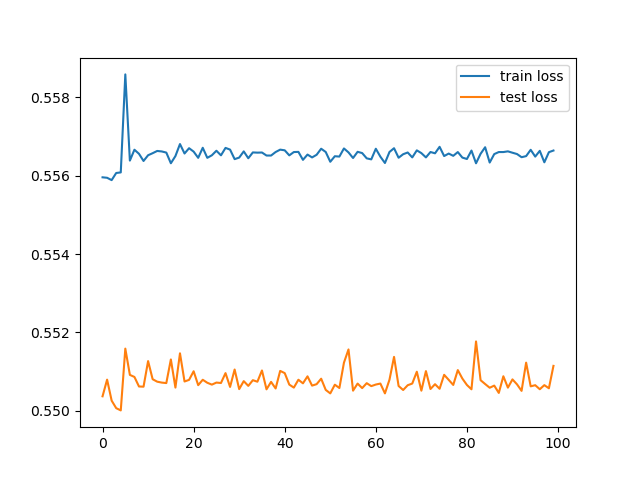

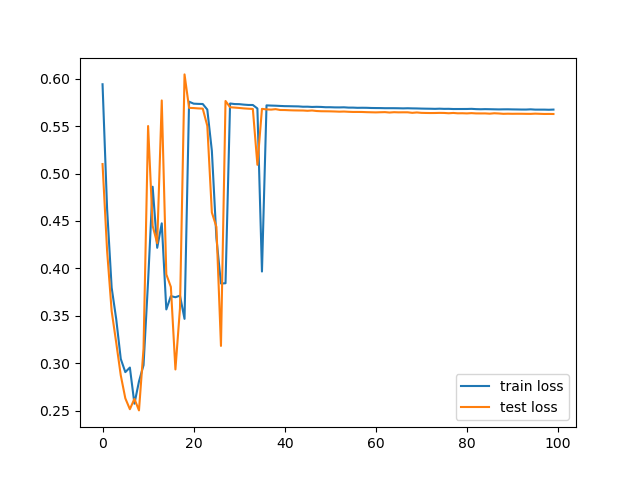

(None, None)

In [42]:
from PIL import Image
from IPython.display import display
img_0_epoch_100 = Image.open('0-epoch-100.png')
img_1_epoch_100 = Image.open('1-epoch-100.png')
display(img_0_epoch_100),display(img_1_epoch_100)

Second, I tried the training with more epochs, 300 and 500 epochs, while the dataset is the same, which means that the split did not run again. The results of this training are shown below. According to the results, I would like to say that the **100 of epoch** is enough to use for the current structure of the network.

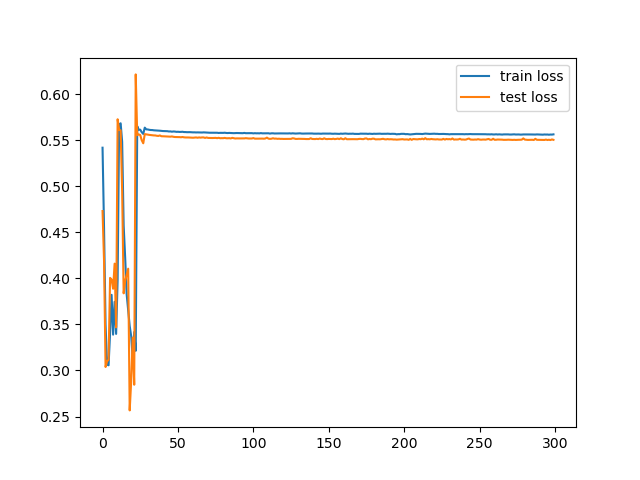

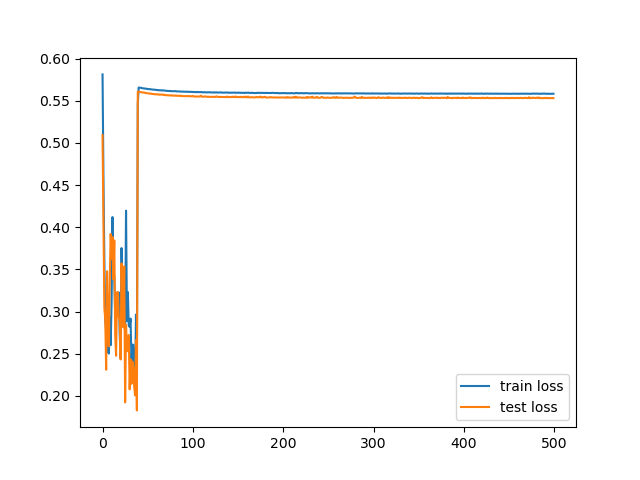

(None, None)

In [43]:
img_epoch_300 = Image.open('1-epoch-300.png')
img_epoch_500 = Image.open('0-epoch-500.png')
display(img_epoch_300),display(img_epoch_500)

I tried more tricks on training, the point is that I have to adjust more parameters such as the network layers, epochs and learning rate. So far, for this network, I found that the more epochs the network trains, the worse overfitting will be.
